In [1]:
import concurrent.futures
import glob
import os
import re
import subprocess
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import circmean
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

In [2]:
def calculate_heading_difference(pre_heading, post_heading):
    # Calculate the angular difference considering the circular nature
    diff = post_heading - pre_heading
    
    # Normalize to [-π, π] range
    return np.arctan2(np.sin(diff), np.cos(diff))

def sg_smooth(array, window_length=51, polyorder=3, **kwargs):
    return savgol_filter(
        array, window_length=window_length, polyorder=polyorder, **kwargs
    )

In [3]:
# Base folder with all slp subfolders (one folder for cs, one for native)
slp_base_folder = "/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/"

# subfolders with CS and native SLP files
cs_slp_folder = os.path.join(slp_base_folder, "wildtype-cs")
native_slp_folder = os.path.join(slp_base_folder, "native")

# Get all subfolders in the CS and native SLP folders
# where each folder is a collection of videos from a different braidz recording
cs_slp_subfolders = sorted(glob.glob(os.path.join(cs_slp_folder, "*")))
native_slp_subfolders = sorted(glob.glob(os.path.join(native_slp_folder, "*")))

# setup output folder
cs_output_folder = "/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/"
native_output_folder = "/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/"
output_folder = "/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/output"

In [24]:
# list all subfolders in a folder
sorted(glob.glob(os.path.join(slp_base_folder, "*")))[:-2]

['/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/20250410_120718',
 '/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/20250411_175919',
 '/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/20250421_174810',
 '/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/20250422_171703',
 '/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/20250425_195715',
 '/gpfs/soma_fs/home/buchsbaum/sleap_projects/highspeed/predictions/20250427_170153']

In [25]:
### THESE FUNCTIONS CONVERT SLP TO CSV ####


# Define a worker function that processes a single file
def process_file(file_info):
    file, exp_output_folder = file_info  # Unpack the tuple

    # set the output filename
    output_file = os.path.join(
        exp_output_folder, os.path.basename(file).replace(".slp", ".csv")
    )

    # if file exists, skip
    if os.path.exists(output_file):
        return f"Skipping {file} (already converted)"

    # convert to csv
    cmd = ["sleap-convert", file, "--format", "analysis.csv", "--output", output_file]

    # To log output to a file instead of discarding it
    with open(os.path.join(exp_output_folder, "conversion.log"), "a") as log_file:
        subprocess.run(cmd, stdout=log_file, stderr=log_file)

    return f"Converted {file}"


def process_folders(input_folders, output_folders, workers=None):
    """
    A function to convert all the slp files from the input folders to csv files in the output folders.
    
    Parameters:
        input_folders (list): List of input folders, each containing slp files.
        output_folders (str): Path to the output folder where the converted files will be saved.
        workers (int): Number of worker processes to use for parallel processing. If None, defaults to the number of CPU cores.
    """
    # loop over each exp folders (meaning, each folder from a braidz file containing all the slp files)
    for exp_folder in input_folders:

        # find all slp files in each folder
        exp_files = sorted(glob.glob(os.path.join(exp_folder, "*.slp")))

        # setup output folder (same name as exp_folder)
        exp_output_folder = os.path.join(
            output_folders, os.path.basename(os.path.normpath(exp_folder))
        )
        os.makedirs(exp_output_folder, exist_ok=True)

        # Prepare input data for process_map
        file_data = [(file, exp_output_folder) for file in exp_files]

        # Process files in parallel with progress bar using process_map
        results = process_map(
            process_file,
            file_data,
            max_workers=workers,
            chunksize=20,
            desc=f"Processing {os.path.basename(exp_folder)}",
            leave=True,
        )

In [26]:
# USAGE EXAMPLE #
process_folders(sorted(glob.glob(os.path.join(slp_base_folder, "*")))[:-2], "/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/output/")

Processing 20250410_120718:   0%|          | 0/18 [00:00<?, ?it/s]

Processing 20250411_175919:   0%|          | 0/101 [00:00<?, ?it/s]

Processing 20250421_174810:   0%|          | 0/85 [00:00<?, ?it/s]

Processing 20250422_171703:   0%|          | 0/31 [00:00<?, ?it/s]

Processing 20250425_195715:   0%|          | 0/10 [00:00<?, ?it/s]

Processing 20250427_170153:   0%|          | 0/125 [00:00<?, ?it/s]

In [7]:
def detect_tracking_gaps(df, min_tracked_frames=10, min_gap_size=20):
    """
    Detects if there are multiple tracking sections separated by NaN gaps in the data.
    
    Parameters:
        df (pd.DataFrame): The dataframe with tracking data (complete_df)
        min_tracked_frames (int): Minimum consecutive frames to consider a valid tracking section
        min_gap_size (int): Minimum size of NaN gap to alert about
        
    Returns:
        bool: True if multiple tracking sections with gaps are detected
    """
    # Create a mask for rows where all tracking points are valid
    valid_mask = (~pd.isna(df['head.x']) & 
                  ~pd.isna(df['head.y']) & 
                  ~pd.isna(df['abdomen.x']) & 
                  ~pd.isna(df['abdomen.y']))
    
    # Convert mask to integers (1 for valid, 0 for NaN)
    valid_series = valid_mask.astype(int)
    
    # Detect changes in the mask (0->1 or 1->0)
    # This creates a series where 1 indicates the start or end of a tracking section
    changes = valid_series.diff().abs()
    
    # Get indices where changes occur
    change_indices = np.where(changes == 1)[0]
    
    # If less than 2 changes, there's only one section or no valid sections
    if len(change_indices) < 2:
        return False
    
    # Calculate segments
    segments = []
    
    # If the first frame is valid, the first change is the end of a segment
    start_idx = 0 if valid_series.iloc[0] == 1 else change_indices[0]
    
    for i in range(1 if valid_series.iloc[0] == 1 else 2, len(change_indices), 2):
        if i >= len(change_indices):
            # If we have an odd number of changes and started with a valid segment
            end_idx = len(valid_series) - 1
        else:
            end_idx = change_indices[i] - 1
            
        # Only include segments that are long enough
        segment_length = end_idx - start_idx + 1
        if segment_length >= min_tracked_frames:
            segments.append((start_idx, end_idx, segment_length))
        
        # Set up for next segment if there are more changes
        if i + 1 < len(change_indices):
            start_idx = change_indices[i + 1]
    
    # If we have only one valid segment, no need to alert
    if len(segments) <= 1:
        return False
    
    # Check gaps between segments
    for i in range(len(segments) - 1):
        current_end = segments[i][1]
        next_start = segments[i + 1][0]
        gap_size = next_start - current_end - 1
        
        if gap_size >= min_gap_size:
            # print(f"ALERT: Multiple tracking sections detected!")
            # print(f"  Section 1: Frames {segments[i][0]}-{segments[i][1]} ({segments[i][2]} frames)")
            # print(f"  Gap: {gap_size} frames with NaNs")
            # print(f"  Section 2: Frames {segments[i+1][0]}-{segments[i+1][1]} ({segments[i+1][2]} frames)")
            return True
    
    return False

In [8]:
def savgol_filter_with_nans(y, window_length, polyorder, **kwargs):
    """
    Apply savgol_filter to an array that contains NaNs.
    The filter is only applied to contiguous segments of non-NaN values.
    
    Parameters:
    -----------
    y : array_like
        The data to be filtered
    window_length : int
        The length of the filter window (must be odd)
    polyorder : int
        The order of the polynomial used to fit the samples
    **kwargs : dict
        Additional arguments to pass to savgol_filter
        
    Returns:
    --------
    y_filtered : ndarray
        The filtered data with NaNs preserved in their original locations
    """
    # Create a copy of the input array to avoid modifying the original
    y_filtered = np.copy(y)
    
    # Find indices of non-NaN values
    valid_indices = ~np.isnan(y)
    
    if not np.any(valid_indices):
        return y_filtered  # Return original if all values are NaN
    
    # Find contiguous segments of valid data
    diff_indices = np.diff(np.concatenate(([0], valid_indices.astype(int), [0])))
    start_indices = np.where(diff_indices == 1)[0]
    end_indices = np.where(diff_indices == -1)[0]
    segments = zip(start_indices, end_indices)
    
    # Apply savgol_filter to each segment separately
    for start, end in segments:
        # Only apply filter if the segment is long enough
        if end - start >= window_length:
            y_filtered[start:end] = savgol_filter(y[start:end], window_length, polyorder, **kwargs)
        # Leave shorter segments unfiltered
    
    return y_filtered

In [14]:

def process_data(stim_csvs_folder, pre_range = [0, 400], post_range = [400, 750]):
    """
    This function accepts a folder with all the csv files that contain the stimulus data as 
    extracted from the braid recording.
    Then, for each file, it finds the correct folder with the converted slp files, and 
    inside that folder finds the correct file that matches each row (obj_id + frame) in the stim csv file.

    It then loads the data from that file, and calculates the heading difference between pre and post
    stimulus data, as well as the heading difference between pre stimulus and the stimulus heading.
    The results are returned as a pandas DataFrame.

    Parameters:
        stim_csvs_folder (str): The folder containing the stimulus CSV files.
        pre_range (list): The range of frames to consider for pre-stimulus data.
        post_range (list): The range of frames to consider for post-stimulus data.

    Returns:
        pd.DataFrame: A DataFrame containing the processed data with heading differences.
    """
    # Create an empty list to collect all the data
    all_data = []

    # get all csv files in the stim_csvs_folder (these are the stim files)
    stim_csvs = sorted(glob.glob(os.path.join(stim_csvs_folder, "*.csv")))
    
    # define pattern recognition for filenames
    pattern = r"obj_id_(\d+)_frame_(\d+)"

    # loop over all files
    for stim_csv in stim_csvs:

        print(f"==== Processing {stim_csv} ====")
        stim_df = pd.read_csv(stim_csv) # read the csv

        # now get the correct folder for the stim file
        slp2csv_folder = os.path.join(stim_csvs_folder,
            os.path.join(os.path.basename(os.path.normpath(stim_csv)).replace(".csv", ""))
            )
        
        # and get all the files from that folder
        slp2csv_files = sorted(glob.glob(os.path.join(slp2csv_folder, "*.csv")))
        
        # loop over the rows of each stim file
        for idx, row in stim_df.iterrows():

            # extract data for each stim row
            stim_obj_id = int(row["obj_id"])
            stim_frame = int(row["frame"])
            stim_heading = float(row["stim_heading"])
            
            # Find the matching csv file
            matching_file = None
            for file in slp2csv_files:
                match = re.search(pattern, file)
                if match:
                    file_obj_id = int(match.group(1))
                    file_frame = int(match.group(2))
                    
                    if file_obj_id == stim_obj_id and file_frame == stim_frame:
                        matching_file = file
                        break
            
            # if no matching file was found, skip
            if matching_file is None:
                continue

            # Load the matching file
            data_df = pd.read_csv(matching_file)

            # Check if the original data has too few tracked frames
            if len(data_df) < 51:
                # print(f"Skipping file with insufficient data: {matching_file}")
                continue

            # Create an empty DataFrame with the same structure as data_df
            complete_df = pd.DataFrame(columns=data_df.columns)
            
            # Set dtypes to match the original dataframe
            for col in data_df.columns:
                complete_df[col] = complete_df[col].astype(data_df[col].dtype)
            
            # Fill the frame_idx column with all possible frames (0-749)
            complete_df['frame_idx'] = list(range(750))
            
            # Set the index to frame_idx for easier merging
            complete_df = complete_df.set_index('frame_idx')
            data_df_indexed = data_df.set_index('frame_idx')
            
            # Update the complete_df with values from the original data_df
            complete_df.update(data_df_indexed)
            
            # Reset index to make frame_idx a column again
            complete_df = complete_df.reset_index()
            

            # Example usage in your code:
            if detect_tracking_gaps(complete_df, min_tracked_frames=10, min_gap_size=20):
                has_tracking_gaps = True

            # Now interpolate to fill the gaps in tracking data
            data_df_interp = complete_df.interpolate(method="linear", limit_direction="both", limit=25)
            
            # extract all data and apply smoothing
            frames = data_df_interp["frame_idx"].to_numpy()
            head_x = savgol_filter_with_nans(data_df_interp["head.x"].to_numpy(), window_length=51, polyorder=3)
            head_y = savgol_filter_with_nans(data_df_interp["head.y"].to_numpy(), window_length=51, polyorder=3)
            abdomen_x = savgol_filter_with_nans(data_df_interp["abdomen.x"].to_numpy(), window_length=51, polyorder=3)
            abdomen_y = savgol_filter_with_nans(data_df_interp["abdomen.y"].to_numpy(), window_length=51, polyorder=3)
            
            # head_x = sg_smooth(data_df_interp["head.x"].to_numpy())
            # head_y = sg_smooth(data_df_interp["head.y"].to_numpy())
            # abdomen_x = sg_smooth(data_df_interp["abdomen.x"].to_numpy())
            # abdomen_y = sg_smooth(data_df_interp["abdomen.y"].to_numpy())

            # extract all frames in pre and post stimulus ranges
            pre_indices = np.where((frames >= pre_range[0]) & (frames < pre_range[1]))[0]
            post_indices = np.where((frames >= post_range[0]) & (frames < post_range[1]))[0]
            
            # Count frames with valid (non-NaN) tracking data in pre-range
            pre_valid_mask = ~np.isnan(head_x[pre_indices]) & ~np.isnan(head_y[pre_indices]) & \
                            ~np.isnan(abdomen_x[pre_indices]) & ~np.isnan(abdomen_y[pre_indices])
            pre_valid_count = np.sum(pre_valid_mask)
            
            # Count frames with valid (non-NaN) tracking data in post-range
            post_valid_mask = ~np.isnan(head_x[post_indices]) & ~np.isnan(head_y[post_indices]) & \
                             ~np.isnan(abdomen_x[post_indices]) & ~np.isnan(abdomen_y[post_indices])
            post_valid_count = np.sum(post_valid_mask)
            
            # Skip if not enough valid frames in these ranges
            if pre_valid_count < 10 or post_valid_count < 10:
                continue
                
            # Keep only valid indices
            pre_indices = pre_indices[pre_valid_mask]
            post_indices = post_indices[post_valid_mask]
            
            # extract pre-stimulus coordinates
            head_x_pre = head_x[pre_indices]
            head_y_pre = head_y[pre_indices]
            abdomen_x_pre = abdomen_x[pre_indices]
            abdomen_y_pre = abdomen_y[pre_indices]

            # extract post-stimulus coordinates
            head_x_post = head_x[post_indices]
            head_y_post = head_y[post_indices]
            abdomen_x_post = abdomen_x[post_indices]
            abdomen_y_post = abdomen_y[post_indices]

            # calculate heading for each frame (angle of vector from abdomen to head)
            pre_heading = np.arctan2(head_y_pre - abdomen_y_pre, head_x_pre - abdomen_x_pre)
            post_heading = np.arctan2(head_y_post - abdomen_y_post, head_x_post - abdomen_x_post)
            
            # calculate circular mean of headings (accounts for circular nature of angle data)
            pre_heading_mean = circmean(pre_heading, high=np.pi, low=-np.pi)
            post_heading_mean = circmean(post_heading, high=np.pi, low=-np.pi)

            # calculate heading differences
            try:
                # Calculate the difference between post-stimulus and pre-stimulus headings
                prepost_heading_difference = calculate_heading_difference(post_heading_mean, pre_heading_mean)
                
                # Calculate the difference between stimulus heading and pre-stimulus heading
                prestim_heading_difference = calculate_heading_difference(stim_heading, pre_heading_mean)
                
                # Create a copy of the row data and add the new calculations
                row_data = row.to_dict()  # Convert the row to a dictionary
                row_data['prepost_heading_difference'] = prepost_heading_difference
                row_data['prestim_heading_difference'] = prestim_heading_difference
                row_data['pre_heading'] = pre_heading_mean
                row_data['post_heading'] = post_heading_mean
                
                # Append to the all_data list
                all_data.append(row_data)
                
            except ValueError as e:
                print(f"Error calculating heading difference: {e}")
                continue

    # Create a DataFrame from all the collected data
    result_df = pd.DataFrame(all_data)

    # Now result_df contains all the data from all files with the heading differences
    print(f"Combined DataFrame has {len(result_df)} rows")
    return result_df

In [15]:
cs_results_df = process_data("/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/")
native_results_df = process_data("/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/")

==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250410_120718.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250411_175919.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250421_174810.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250422_171703.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250425_195715.csv ====
Combined DataFrame has 217 rows
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/20241112_124059.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/20241114_173118.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/20241116_154109.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/native/20241125_132912.csv ====
==== Processing /gpfs/soma_fs/home/buchs

In [10]:
cs_results_df = process_data("/gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/")

==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20241121_151406.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20241126_171308.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20241130_161634.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250102_152013.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250110_142709.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250111_151946.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250410_120718.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250411_175919.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_analysis/canton-s/20250421_174810.csv ====
==== Processing /gpfs/soma_fs/home/buchsbaum/src/sleap_video_ana

In [19]:
def plot_correlation(df, col1, col2, use_abs=False, convert_to_degrees=True, title=None, 
                     xlabel=None, ylabel=None, figsize=(10, 6), size_scale=2, min_size=10, max_size=200):
    """
    Plot correlation between two columns in the dataframe with dot size based on absolute turn angle.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data to plot
    col1 : str

        The name of the first column to plot (x-axis)
    col2 : str
        The name of the second column to plot (y-axis)
    use_abs : bool, default=False
        Whether to use absolute values for the columns
    convert_to_degrees : bool, default=True
        Whether to convert radian values to degrees
    title : str, optional
        Custom title for the plot
    xlabel : str, optional
        Custom label for x-axis
    ylabel : str, optional
        Custom label for y-axis
    figsize : tuple, default=(10, 6)
        Figure size as (width, height) in inches
    size_scale : float, default=3
        Scaling factor for dot sizes
    min_size : float, default=10
        Minimum dot size
    max_size : float, default=200
        Maximum dot size
    """
    # Create a copy to avoid modifying the original dataframe
    plot_df = df.copy()
    
    # Process the columns based on parameters
    x_col = f'abs_{col1}' if use_abs else col1
    y_col = f'abs_{col2}' if use_abs else col2
    
    # Create absolute value columns if needed
    if use_abs:
        plot_df[x_col] = np.abs(plot_df[col1])
        plot_df[y_col] = np.abs(plot_df[col2])
    
    # Convert to degrees if requested
    if convert_to_degrees:
        x_col_plot = f'{x_col}_deg'
        y_col_plot = f'{y_col}_deg'
        plot_df[x_col_plot] = np.degrees(plot_df[x_col])
        plot_df[y_col_plot] = np.degrees(plot_df[y_col])
    else:
        x_col_plot = x_col
        y_col_plot = y_col
    
    # Generate labels if not provided
    if xlabel is None:
        prefix = '|' if use_abs else ''
        suffix = '|' if use_abs else ''
        unit = ' (degrees)' if convert_to_degrees else ' (radians)'
        xlabel = f"{prefix}{col1}{suffix}{unit}"
    
    if ylabel is None:
        prefix = '|' if use_abs else ''
        suffix = '|' if use_abs else ''
        unit = ' (degrees)' if convert_to_degrees else ' (radians)'
        ylabel = f"{prefix}{col2}{suffix}{unit}"
    
    if title is None:
        abs_prefix = "Absolute " if use_abs else ""
        title = f"{abs_prefix}Correlation: {col1} vs {col2}"
    
    # Calculate dot sizes based on absolute turn angle (y_col)
    # Create a normalized size that scales with the absolute turn angle
    abs_turn = np.abs(plot_df[y_col])
    
    # Scale the sizes between min_size and max_size
    if len(abs_turn) > 0:
        if abs_turn.max() > abs_turn.min():
            # Normalize and scale
            normalized_sizes = min_size + (abs_turn - abs_turn.min()) / (abs_turn.max() - abs_turn.min()) * (max_size - min_size)
        else:
            # If all values are the same, use a default size
            normalized_sizes = np.ones_like(abs_turn) * ((min_size + max_size) / 2)
            
        # Apply additional scaling factor
        dot_sizes = normalized_sizes * size_scale
    else:
        dot_sizes = np.array([min_size])
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Scatter plot with scaled dot sizes
    scatter = plt.scatter(plot_df[x_col_plot], plot_df[y_col_plot], 
                         s=dot_sizes, alpha=0.6, 
                         c=abs_turn, cmap='viridis')
    
    # Add colorbar to show the relationship between dot size and turn angle
    cbar = plt.colorbar(scatter)
    cbar.set_label('Absolute Turn Angle' + (' (radians)' if not convert_to_degrees else ' (degrees)'))
    
    # Add trend line
    sns.regplot(x=x_col_plot, y=y_col_plot, data=plot_df, 
                scatter=False, color='red', line_kws={'linewidth': 2})
    
    # Calculate and display correlation coefficient
    corr = plot_df[x_col].corr(plot_df[y_col])
    plt.annotate(f'r = {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Return the plot for further customization if needed
    return plt

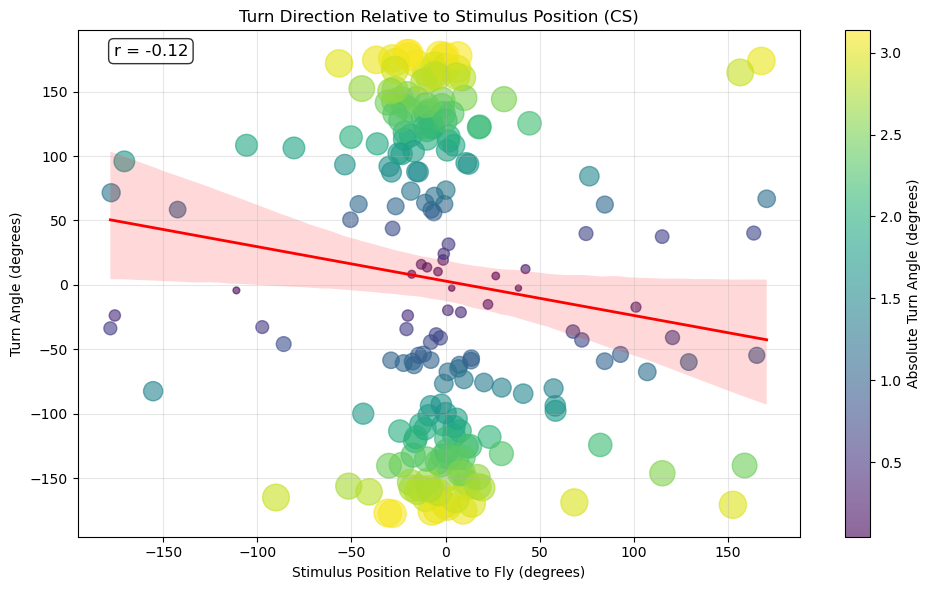

In [27]:
"""
This plot shows if flies turn toward or away from the stimulus

A negative correlation means flies tend to turn away from the stimulus
A positive correlation means flies tend to turn toward the stimulus
If points are in opposite quadrants (top-left and bottom-right), this indicates turning away
Look at the trend line slope to determine the dominant behavior
"""
p = plot_correlation(cs_results_df, 'prestim_heading_difference', 'prepost_heading_difference', 
                 use_abs=False, 
                 title='Turn Direction Relative to Stimulus Position (CS)',
                 xlabel='Stimulus Position Relative to Fly (degrees)',
                 ylabel='Turn Angle (degrees)')

# p = plot_correlation(native_results_df, 'prestim_heading_difference', 'prepost_heading_difference', 
#                  use_abs=False, 
#                  title='Turn Direction Relative to Stimulus Position (Native)',
#                  xlabel='Stimulus Position Relative to Fly (degrees)',
#                  ylabel='Turn Angle (degrees)')

<module 'matplotlib.pyplot' from '/gpfs/soma_fs/home/buchsbaum/miniforge3/envs/sleap/lib/python3.7/site-packages/matplotlib/pyplot.py'>

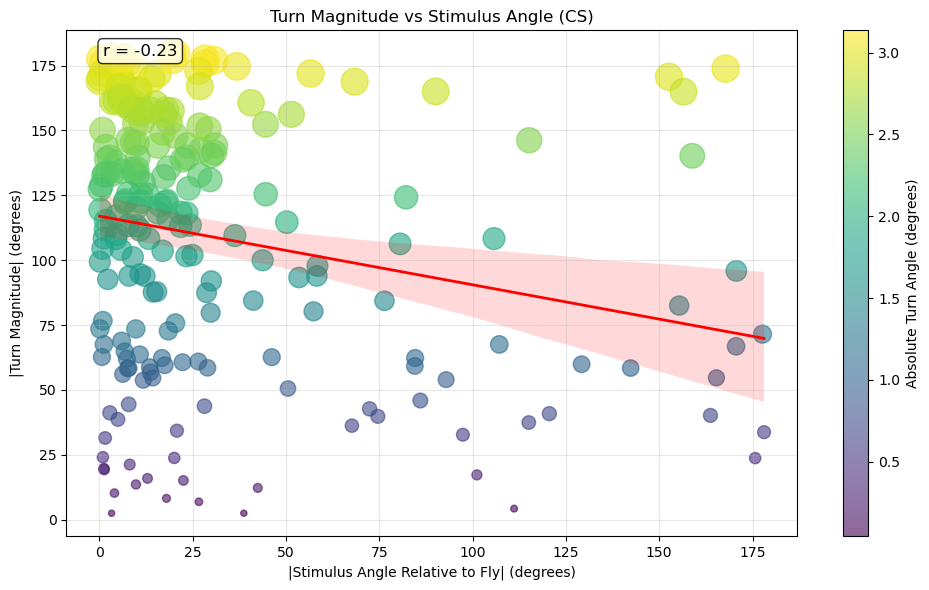

In [21]:
"""
This plot shows if stimulus angle affects turn amplitude
This shows if flies make sharper turns when stimuli come from certain angles
A positive correlation suggests stronger turns when the stimulus is more lateral
A flat line suggests turn magnitude is independent of stimulus position
"""
plot_correlation(cs_results_df, 'prestim_heading_difference', 'prepost_heading_difference', 
                 use_abs=True,
                 title='Turn Magnitude vs Stimulus Angle (CS)',
                 xlabel='|Stimulus Angle Relative to Fly| (degrees)',
                 ylabel='|Turn Magnitude| (degrees)')

# plot_correlation(native_results_df, 'prestim_heading_difference', 'prepost_heading_difference', 
#                  use_abs=True,
#                  title='Turn Magnitude vs Stimulus Angle (Native)',
#                  xlabel='|Stimulus Angle Relative to Fly| (degrees)',
#                  ylabel='|Turn Magnitude| (degrees)')


<module 'matplotlib.pyplot' from '/gpfs/soma_fs/home/buchsbaum/miniforge3/envs/sleap/lib/python3.7/site-packages/matplotlib/pyplot.py'>

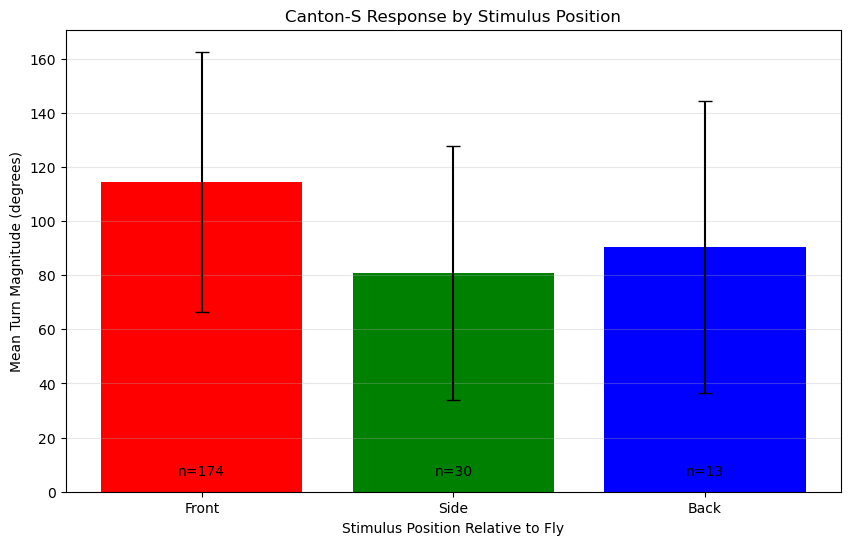

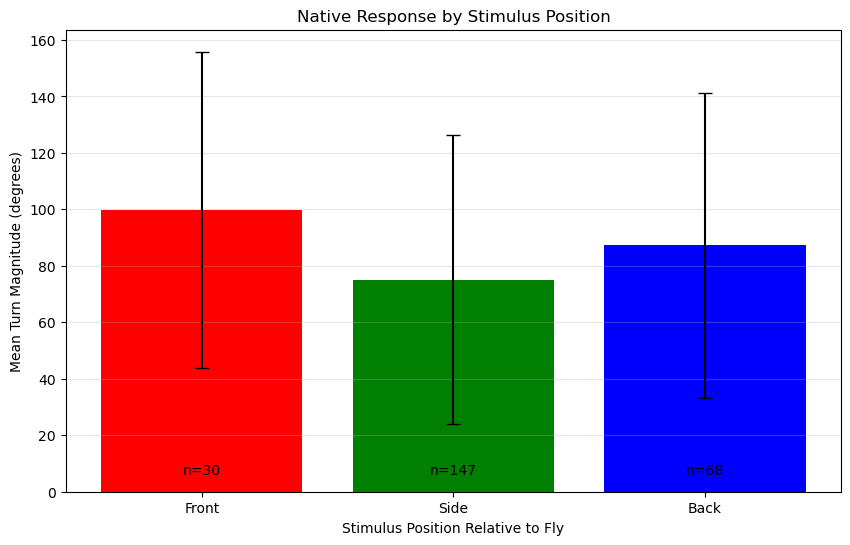

In [22]:
def analyze_directional_response(df, title="Directional Response Analysis"):
    # Create a copy of the dataframe
    analysis_df = df.copy()
    
    # Convert to degrees for easier interpretation
    analysis_df['prestim_deg'] = np.degrees(analysis_df['prestim_heading_difference'])
    analysis_df['turn_magnitude'] = np.abs(np.degrees(analysis_df['prepost_heading_difference']))
    
    # create the position categories manually
    def get_position(angle):
        angle = ((angle + 180) % 360) - 180  # Normalize to [-180, 180]
        if -45 <= angle <= 45:
            return 'Front'
        elif 135 <= angle <= 180 or -180 <= angle <= -135:
            return 'Back'
        else:
            return 'Side'
    
    # Apply the function to create position categories
    analysis_df['position'] = analysis_df['prestim_deg'].apply(get_position)
    
    # Calculate statistics for each position
    position_stats = analysis_df.groupby('position')['turn_magnitude'].agg(
        ['mean', 'std', 'count']).reset_index()
    
    # For consistent visual ordering
    position_order = ['Front', 'Side', 'Back']
    position_stats['position'] = pd.Categorical(
        position_stats['position'], 
        categories=position_order, 
        ordered=True
    )
    position_stats = position_stats.sort_values('position')
    
    # Colors for the bars
    colors = {'Front': 'red', 'Side': 'green', 'Back': 'blue'}
    bar_colors = [colors[pos] for pos in position_stats['position']]
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    
    # Create bar plot with error bars
    bars = plt.bar(position_stats['position'], position_stats['mean'], 
            yerr=position_stats['std'], capsize=5, color=bar_colors)
    
    # Add count labels
    for i, bar in enumerate(bars):
        count = position_stats['count'].iloc[i]
        plt.text(bar.get_x() + bar.get_width()/2, 5, 
                 f'n={count}', ha='center', va='bottom')
    
    plt.xlabel('Stimulus Position Relative to Fly')
    plt.ylabel('Mean Turn Magnitude (degrees)')
    plt.title(title)
    plt.grid(True, alpha=0.3, axis='y')
    
    return plt

# Compare both strains
analyze_directional_response(cs_results_df, "Canton-S Response by Stimulus Position")
analyze_directional_response(native_results_df, "Native Response by Stimulus Position")

In [ ]:
def analyze_turn_direction(df, title="Turn Direction Analysis"):
    """
    Analyze whether flies turned toward or away from the stimulus.
    """
    # Create a copy of the dataframe
    analysis_df = df.copy()
    
    # Calculate post-stimulus to stimulus heading difference
    analysis_df['poststim_diff'] = np.abs(np.degrees(
        calculate_heading_difference(
            analysis_df['stim_heading'], 
            analysis_df['post_heading']
        )
    ))
    
    # Get absolute pre-stimulus heading difference
    analysis_df['prestim_diff_abs'] = np.abs(np.degrees(analysis_df['prestim_heading_difference']))
    
    # We need to check if the fly turned in the direction that would take it away from the stimulus
    # First, get the sign of the prestim_heading_difference to know which direction the stimulus is
    stimulus_direction = np.sign(analysis_df['prestim_heading_difference'])
    
    # Then get the sign of the turn (prepost_heading_difference)
    turn_direction = np.sign(analysis_df['prepost_heading_difference'])
    
    # If stimulus_direction and turn_direction are opposite, the fly turned away
    # If they're the same, the fly turned toward
    # For aversive stimuli, flies should turn away (opposite signs)
    analysis_df['turn_direction'] = np.where(
        stimulus_direction * turn_direction < 0,  # Opposite signs
        'Away',  # This is the expected behavior for aversive stimulus
        'Toward'  # This is turning toward the stimulus
    )
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 10))
    
    # 1. Scatter plot of turn direction
    ax1 = fig.add_subplot(121)
    
    # Convert to degrees for plot
    prestim_deg = np.degrees(analysis_df['prestim_heading_difference'])
    turn_deg = np.degrees(analysis_df['prepost_heading_difference'])
    
    # Color by direction
    colors = np.where(analysis_df['turn_direction'] == 'Toward', 'green', 'red')
    
    # Scale point size by turn magnitude (normalized)
    sizes = 10 + (np.abs(turn_deg) / np.abs(turn_deg).max() * 100)
    
    # Create scatter plot
    ax1.scatter(prestim_deg, turn_deg, c=colors, s=sizes, alpha=0.7)
    
    # Add reference lines
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    ax1.set_xlabel('Stimulus Position Relative to Fly (degrees)')
    ax1.set_ylabel('Turn Angle (degrees)')
    ax1.set_title('Turn Direction by Stimulus Position')
    ax1.grid(True, alpha=0.3)
    
    # Add a custom legend
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)
    ]
    ax1.legend(custom_lines, ['Toward Stimulus', 'Away from Stimulus'], 
              loc='upper right')
    
    # 2. Polar plot of turn direction
    ax2 = fig.add_subplot(122, projection='polar')
    
    # Use the original prestim_heading_difference for theta
    theta = analysis_df['prestim_heading_difference']
    
    # Use absolute turn magnitude for radius
    r = np.abs(analysis_df['prepost_heading_difference'])
    
    # Create polar scatter plot
    ax2.scatter(theta, r, c=colors, s=sizes, alpha=0.7)
    
    # Configure the polar plot
    ax2.set_theta_zero_location("N")  # 0 at the top (front)
    ax2.set_theta_direction(-1)       # clockwise
    
    # Add labels around the circle
    labels = ['Front', '', 'Right', '', 'Back', '', 'Left', '']
    ax2.set_xticks(np.pi/4 * np.arange(8))
    ax2.set_xticklabels(labels)
    
    # Add legend to polar plot
    ax2.legend(custom_lines, ['Toward Stimulus', 'Away from Stimulus'], 
              loc='upper right')
    
    # Add title
    ax2.set_title('Turn Response by Stimulus Direction (Polar)')
    
    # Add overall percentages to the figure
    toward_percent = 100 * (analysis_df['turn_direction'] == 'Toward').sum() / len(analysis_df)
    away_percent = 100 - toward_percent
    
    plt.figtext(0.5, 0.95, f"{title}: {toward_percent:.1f}% Toward, {away_percent:.1f}% Away", 
                ha='center', fontsize=14, fontweight='bold')
    
    # Add position-based analysis
    bins = [-np.pi, -2*np.pi/3, -np.pi/3, 0, np.pi/3, 2*np.pi/3, np.pi]
    labels = ['Back-Left', 'Left', 'Front-Left', 'Front-Right', 'Right', 'Back-Right']
    
    analysis_df['position_bin'] = pd.cut(
        analysis_df['prestim_heading_difference'], 
        bins=bins, 
        labels=labels,
        ordered=False
    )
    
    # Calculate percentage turning toward for each position
    direction_by_pos = analysis_df.groupby('position_bin')['turn_direction'].apply(
        lambda x: (x == 'Toward').mean() * 100
    ).reset_index()
    
    # Print position-based statistics
    print(f"\n{title} - Percentage turning toward stimulus by position:")
    for _, row in direction_by_pos.iterrows():
        count = len(analysis_df[analysis_df['position_bin'] == row['position_bin']])
        print(f"{row['position_bin']}: {row['turn_direction']:.1f}% toward (n={count})")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig, analysis_df

# Apply to both datasets
fig_cs, cs_direction_df = analyze_turn_direction(cs_results_df, "Canton-S")
fig_native, native_direction_df = analyze_turn_direction(native_results_df, "Native")

In [ ]:
def unwrap_with_nan(array):
    array[~np.isnan(array)] = np.unwrap(array[~np.isnan(array)])
    return array

In [ ]:
"""
Added a more comprehensive analysis with:
1. A direct comparison of Canton-S vs Native for each stimulus position
2. Circular statistics to evaluate the angular distribution
"""

def compare_strains_by_position(cs_df, native_df, title="Strain Comparison by Stimulus Position"):
    """
    Compare turn responses between Canton-S and Native flies for each stimulus position.
    """
    # Prepare data
    cs_plot = cs_df.copy()
    native_plot = native_df.copy()
    
    # Convert angles to degrees
    for df in [cs_plot, native_plot]:
        df['prestim_deg'] = np.degrees(df['prestim_heading_difference'])
        df['turn_deg'] = np.degrees(df['prepost_heading_difference'])
        
        # Categorize positions
        df['position'] = df['prestim_deg'].apply(lambda angle: 
            'Front' if -45 <= ((angle + 180) % 360) - 180 <= 45 else
            'Right' if 45 < ((angle + 180) % 360) - 180 <= 135 else
            'Left' if -135 <= ((angle + 180) % 360) - 180 < -45 else
            'Back'
        )
    
    # Create a figure
    fig, axs = plt.subplots(2, 2, figsize=(16, 14), sharex=True)
    axs = axs.flatten()
    
    # Define positions and colors
    positions = ['Front', 'Right', 'Back', 'Left']
    
    # Set up histogram bins
    bins = np.arange(-180, 181, 15)
    
    # Plot for each position
    for i, position in enumerate(positions):
        # Extract data for this position
        cs_pos_data = cs_plot[cs_plot['position'] == position]['turn_deg']
        native_pos_data = native_plot[native_plot['position'] == position]['turn_deg']
        
        # Skip if no data for one strain
        if len(cs_pos_data) == 0 or len(native_pos_data) == 0:
            axs[i].text(0.5, 0.5, f'Insufficient data for {position}', 
                       transform=axs[i].transAxes, fontsize=14, ha='center')
            continue
        
        # Plot histograms
        axs[i].hist(cs_pos_data, bins=bins, color='red', alpha=0.5, 
                   edgecolor='black', label=f'Canton-S (n={len(cs_pos_data)})')
        axs[i].hist(native_pos_data, bins=bins, color='blue', alpha=0.5, 
                   edgecolor='black', label=f'Native (n={len(native_pos_data)})')
        
        # Calculate medians
        cs_median = np.median(cs_pos_data)
        native_median = np.median(native_pos_data)
        
        # Add median lines
        axs[i].axvline(x=cs_median, color='red', linestyle='--', 
                      label=f'CS Median: {cs_median:.1f}°')
        axs[i].axvline(x=native_median, color='blue', linestyle='--', 
                      label=f'Native Median: {native_median:.1f}°')
        
        # Add reference lines
        axs[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        axs[i].axvline(x=90, color='gray', linestyle=':', alpha=0.5)
        axs[i].axvline(x=-90, color='gray', linestyle=':', alpha=0.5)
        
        # Calculate percentage of expected responses for each strain
        if position == 'Front':
            cs_expected = (np.abs(cs_pos_data) > 90).mean() * 100
            native_expected = (np.abs(native_pos_data) > 90).mean() * 100
            expected_text = f"Turn >90° away: CS={cs_expected:.1f}%, Native={native_expected:.1f}%"
        elif position == 'Right':
            cs_expected = (cs_pos_data < 0).mean() * 100
            native_expected = (native_pos_data < 0).mean() * 100
            expected_text = f"Turn left: CS={cs_expected:.1f}%, Native={native_expected:.1f}%"
        elif position == 'Left':
            cs_expected = (cs_pos_data > 0).mean() * 100
            native_expected = (native_pos_data > 0).mean() * 100
            expected_text = f"Turn right: CS={cs_expected:.1f}%, Native={native_expected:.1f}%"
        else:  # Back
            cs_expected = (np.abs(cs_pos_data) < 90).mean() * 100
            native_expected = (np.abs(native_pos_data) < 90).mean() * 100
            expected_text = f"Turn <90°: CS={cs_expected:.1f}%, Native={native_expected:.1f}%"
        
        # Add text with expected response percentages
        axs[i].text(0.5, 0.95, expected_text, transform=axs[i].transAxes, 
                   fontsize=12, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Set title and labels
        axs[i].set_title(f'Stimulus from {position}', fontsize=14)
        axs[i].set_xlabel('Turn Angle (degrees)', fontsize=12)
        axs[i].set_ylabel('Frequency', fontsize=12)
        axs[i].legend()
    
    # Set the same x-limits for all subplots
    for ax in axs:
        ax.set_xlim(-180, 180)
    
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig

# Create comparison plot
fig_comparison = compare_strains_by_position(cs_results_df, native_results_df, 
                                         "Canton-S vs Native: Turn Response by Stimulus Position")